In [1]:
import tensorflow as tf
import tensorflow.contrib as tcb
from tensorflow.contrib.learn.python.learn.learn_io.numpy_io import numpy_input_fn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import time

In [2]:
def model_fn(features, labels, mode, params):
    # get features

    X = features["X"]
    Y = features["Y"]
    
    inputs = tf.concat([X, Y], axis = 1) # b * 2
    print(X.shape, Y.shape, labels.shape, inputs.shape)

    p = params.get("p", 1)
    xavier = tcb.layers.xavier_initializer(seed=42)
    W = tf.get_variable("W", shape=(2, p), dtype = tf.float64) # 2 * p
    b = tf.get_variable("b", shape=(1, p), dtype = tf.float64) # 1 * p but will get broadcasted to batch size by tf => b * p
    
    initializer = tcb.layers.xavier_initializer(seed=42)
    out1 = tf.matmul(inputs, W) + b # b * p
    out2 = tf.nn.relu(out1) # b * p
    predictions = tcb.layers.fully_connected(out2, num_outputs=1, weights_initializer=None, activation_fn=None)
#     w_outer = tf.get_variable("w_outer", shape=[p, 1], dtype=tf.float64) # p x 1
#     b_outer = tf.get_variable("b_outer", shape=[1, 1], dtype=tf.float64) # 1 x 1
    
#     out3 = tf.matmul(out2, w_outer)  + b_outer
#     predictions = tf.nn.tanh(out3)# b x 1
    # prediction part

    if mode == tcb.learn.ModeKeys.INFER:
        return tcb.learn.ModelFnOps(
            mode= mode,
            predictions = predictions,
            loss = None,
            train_op = None
        )

    # training part => fit

    loss = tf.losses.mean_squared_error(labels, predictions)
    learning_rate = params.get("learning_rate", 1e-5)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    tf.Print(loss, [inputs, labels])
    
    global_step = tf.contrib.framework.get_global_step()
    train_op = tf.group(optimizer, tf.assign_add(global_step, 1))

#     train_op = tcb.layers.optimize_loss(loss=loss,
#                                         global_step = tf.contrib.framework.get_global_step(),
#                                         learning_rate=learning_rate,
#                                         optimizer = "SGD")

    return tcb.learn.ModelFnOps(
        mode = mode,
        predictions = predictions,
        loss = loss,
        train_op = train_op
    )


In [3]:
import numpy as np
# X = np.array(range(1, 51) ,dtype=np.float64).reshape(-1, 1) *  1.0
# Y = np.array(range(0, 100, 2), dtype=np.float64).reshape(-1, 1) * 1.0
# X1, Y1 = np.meshgrid(X, Y)
# X = X1.reshape(-1, 1)
# Y = Y1.reshape(-1, 1)
# Z = X + Y
# print(X.shape, Y.shape, Z.shape)

X = np.linspace(-5,5, num = 50)
Y = np.linspace(-5,5, num = 50)
X, Y = np.meshgrid(X, Y)

Z = 100*np.exp(-1*(X**2 + Y**2)/5)

X = X.reshape(-1,1)
Y = Y.reshape(-1,1)
Z = Z.reshape(-1,1)

In [4]:
input_fn = numpy_input_fn(x= {"X": X, "Y": Y}, y = Z, batch_size=100, num_epochs=1000, shuffle=True)

In [5]:
estimator = tcb.learn.Estimator(model_fn=model_fn, params={"learning_rate": 1e-5, "p": 1000}, config=tcb.learn.RunConfig(log_device_placement=False, gpu_memory_fraction=0.8))

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5dcc890048>, '_master': '', '_num_ps_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 0.8
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000}


In [6]:
start = time.time()
y = estimator.fit(input_fn=input_fn)

(?, 1) (?, 1) (?, 1) (?, 2)
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpixh7xy70/model.ckpt.
INFO:tensorflow:loss = 1589.94, step = 1
INFO:tensorflow:global_step/sec: 274.16
INFO:tensorflow:loss = 1457.05, step = 101
INFO:tensorflow:global_step/sec: 276.911
INFO:tensorflow:loss = 1142.81, step = 201
INFO:tensorflow:global_step/sec: 279.623
INFO:tensorflow:loss = 1280.12, step = 301
INFO:tensorflow:global_step/sec: 294.421
INFO:tensorflow:loss = 1614.05, step = 401
INFO:tensorflow:global_step/sec: 298.978
INFO:tensorflow:loss = 1277.56, step = 501
INFO:tensorflow:global_step/sec: 302.767
INFO:tensorflow:loss = 1190.86, step = 601
INFO:tensorflow:global_step/sec: 304.328
INFO:tensorflow:loss = 1254.24, step = 701
INFO:tensorflow:global_step/sec: 298.576
INFO:tensorflow:loss = 1260.11, step = 801
INFO:tensorflow:global_step/sec: 277.564
INFO:tensorflow:loss = 1382.37, step = 901
INFO:tensorflow:global_step/sec: 267.336
INFO:tensorflow:

INFO:tensorflow:loss = 780.29, step = 9501
INFO:tensorflow:global_step/sec: 257.264
INFO:tensorflow:loss = 940.231, step = 9601
INFO:tensorflow:global_step/sec: 255.564
INFO:tensorflow:loss = 516.907, step = 9701
INFO:tensorflow:global_step/sec: 253.379
INFO:tensorflow:loss = 1308.93, step = 9801
INFO:tensorflow:global_step/sec: 248.91
INFO:tensorflow:loss = 956.672, step = 9901
INFO:tensorflow:global_step/sec: 252.981
INFO:tensorflow:loss = 852.256, step = 10001
INFO:tensorflow:global_step/sec: 246.436
INFO:tensorflow:loss = 895.578, step = 10101
INFO:tensorflow:global_step/sec: 252.804
INFO:tensorflow:loss = 1087.72, step = 10201
INFO:tensorflow:global_step/sec: 252.557
INFO:tensorflow:loss = 784.24, step = 10301
INFO:tensorflow:global_step/sec: 251.31
INFO:tensorflow:loss = 883.664, step = 10401
INFO:tensorflow:global_step/sec: 255.708
INFO:tensorflow:loss = 907.483, step = 10501
INFO:tensorflow:global_step/sec: 259.841
INFO:tensorflow:loss = 803.319, step = 10601
INFO:tensorflow:gl

INFO:tensorflow:loss = 603.439, step = 19101
INFO:tensorflow:global_step/sec: 254.231
INFO:tensorflow:loss = 576.023, step = 19201
INFO:tensorflow:global_step/sec: 254.919
INFO:tensorflow:loss = 669.907, step = 19301
INFO:tensorflow:global_step/sec: 259.576
INFO:tensorflow:loss = 512.032, step = 19401
INFO:tensorflow:global_step/sec: 254.513
INFO:tensorflow:loss = 626.286, step = 19501
INFO:tensorflow:global_step/sec: 252.962
INFO:tensorflow:loss = 383.165, step = 19601
INFO:tensorflow:global_step/sec: 256.211
INFO:tensorflow:loss = 460.338, step = 19701
INFO:tensorflow:global_step/sec: 253.461
INFO:tensorflow:loss = 446.333, step = 19801
INFO:tensorflow:global_step/sec: 267.682
INFO:tensorflow:loss = 754.92, step = 19901
INFO:tensorflow:global_step/sec: 253.447
INFO:tensorflow:loss = 566.823, step = 20001
INFO:tensorflow:global_step/sec: 253.744
INFO:tensorflow:loss = 622.117, step = 20101
INFO:tensorflow:global_step/sec: 251.605
INFO:tensorflow:loss = 596.224, step = 20201
INFO:tenso

In [7]:
print("Time to run", time.time() - start)
predict_input_fn = numpy_input_fn(x= {"X": X, "Y": Y}, y = Z, batch_size=5, num_epochs=1, shuffle=False)
Zgo = estimator.predict(input_fn=predict_input_fn)
Zout = np.array([x[0] for x in Zgo]).reshape(-1,1)

Time to run 97.58821630477905
(?, 1) (?, 1) (?, 1) (?, 2)


In [4]:
def plot3d(x, y, z, zpred, title=None):
    l = int(np.sqrt(X.shape[0]))
    x1 = x.reshape(l,l)
    y1 = y.reshape(l,l)
    z1 = z.reshape(l,l)
    zpred1 = zpred.reshape(l,l)

    fig = plt.figure(figsize=(15,6))
    if title:
        fig.suptitle(title)
    ax = fig.add_subplot(1,2,1, projection='3d')
    surf = ax.plot_surface(x1, y1, zpred1, cmap=cm.coolwarm,
                           linewidth=0, antialiased=True)
    ax.set_title("Pred")
    ax = fig.add_subplot(1,2,2, projection='3d')
    surf = ax.plot_surface(x1,y1, zpred1 - z1, cmap=cm.coolwarm, antialiased=True)
    ax.set_title("Errors")
    plt.show()

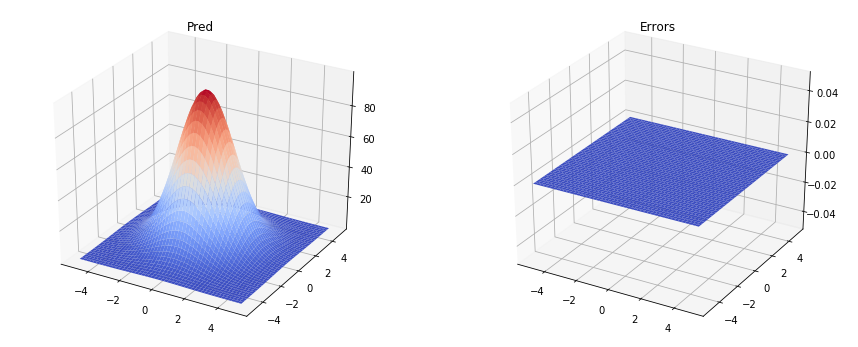

In [9]:
plot3d(X,Y,Z,Z)

In [10]:
Zout

array([[-12.94413412],
       [-11.78387776],
       [-10.63442403],
       ..., 
       [-10.53883548],
       [-11.67303959],
       [-12.81480611]])

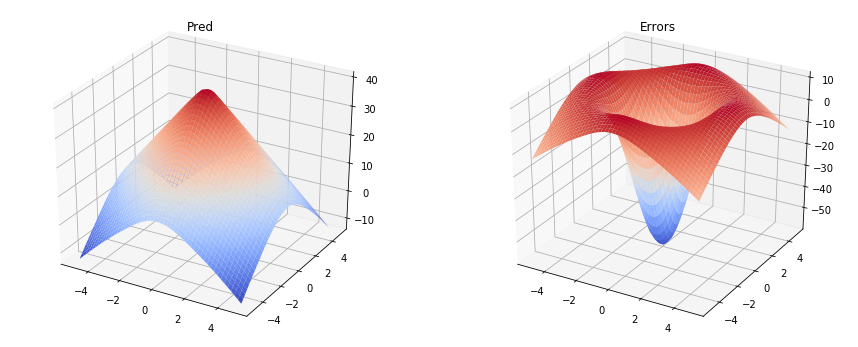

In [11]:
plot3d(X,Y,Z,Zout)

In [12]:
estimator.evaluate(input_fn=predict_input_fn)

(?, 1) (?, 1) (?, 1) (?, 2)
INFO:tensorflow:Starting evaluation at 2018-01-26-06:38:42
INFO:tensorflow:Finished evaluation at 2018-01-26-06:38:43
INFO:tensorflow:Saving dict for global step 25001: global_step = 25001, loss = 213.614


{'global_step': 25001, 'loss': 213.61362}

In [13]:
# Creates a graph.
a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))

[[ 22.  28.]
 [ 49.  64.]]


# multi layer

In [5]:
def model_fn2(features, labels, mode, params):
    # get features

    X = features["X"]
    Y = features["Y"]
    
    inputs = tf.concat([X, Y], axis = 1) # b * 2
    print(X.shape, Y.shape, labels.shape, inputs.shape)

    p = params.get("p", [1])
    predictions = inputs
    for hs in p:
        predictions = tcb.layers.fully_connected(predictions, num_outputs=hs, weights_initializer=None, activation_fn=tf.nn.relu)
#     w_outer = tf.get_variable("w_outer", shape=[p, 1], dtype=tf.float64) # p x 1
#     b_outer = tf.get_variable("b_outer", shape=[1, 1], dtype=tf.float64) # 1 x 1
    predictions = tcb.layers.fully_connected(predictions, num_outputs=1, weights_initializer=None, activation_fn=None)
#     out3 = tf.matmul(out2, w_outer)  + b_outer
#     predictions = tf.nn.tanh(out3)# b x 1
    # prediction part

    if mode == tcb.learn.ModeKeys.INFER:
        return tcb.learn.ModelFnOps(
            mode= mode,
            predictions = predictions,
            loss = None,
            train_op = None
        )

    # training part => fit

    loss = tf.losses.mean_squared_error(labels, predictions)
    learning_rate = params.get("learning_rate", 1e-5)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    tf.Print(loss, [inputs, labels])
    
    global_step = tf.contrib.framework.get_global_step()
    train_op = tf.group(optimizer, tf.assign_add(global_step, 1))

#     train_op = tcb.layers.optimize_loss(loss=loss,
#                                         global_step = tf.contrib.framework.get_global_step(),
#                                         learning_rate=learning_rate,
#                                         optimizer = "SGD")

    return tcb.learn.ModelFnOps(
        mode = mode,
        predictions = predictions,
        loss = loss,
        train_op = train_op
    )


In [15]:
estimator = tcb.learn.Estimator(model_fn=model_fn2, params={"learning_rate": 1e-5, "p": [100,10]}, config=tcb.learn.RunConfig(log_device_placement=False, gpu_memory_fraction=0.8))

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5d6c534a20>, '_master': '', '_num_ps_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 0.8
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000}


In [16]:
start = time.time()
y = estimator.fit(input_fn=input_fn)

(?, 1) (?, 1) (?, 1) (?, 2)
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpyx3esxtt/model.ckpt.
INFO:tensorflow:loss = 1617.56, step = 1
INFO:tensorflow:global_step/sec: 234.698
INFO:tensorflow:loss = 1341.68, step = 101
INFO:tensorflow:global_step/sec: 240.766
INFO:tensorflow:loss = 1314.98, step = 201
INFO:tensorflow:global_step/sec: 242.171
INFO:tensorflow:loss = 1040.61, step = 301
INFO:tensorflow:global_step/sec: 238.396
INFO:tensorflow:loss = 1139.08, step = 401
INFO:tensorflow:global_step/sec: 243.703
INFO:tensorflow:loss = 1568.35, step = 501
INFO:tensorflow:global_step/sec: 236.553
INFO:tensorflow:loss = 1723.02, step = 601
INFO:tensorflow:global_step/sec: 237.816
INFO:tensorflow:loss = 1125.75, step = 701
INFO:tensorflow:global_step/sec: 237.743
INFO:tensorflow:loss = 1236.82, step = 801
INFO:tensorflow:global_step/sec: 238.849
INFO:tensorflow:loss = 1437.67, step = 901
INFO:tensorflow:global_step/sec: 236.543
INFO:tensorflow

INFO:tensorflow:loss = 664.587, step = 9501
INFO:tensorflow:global_step/sec: 230.046
INFO:tensorflow:loss = 675.69, step = 9601
INFO:tensorflow:global_step/sec: 233.765
INFO:tensorflow:loss = 631.811, step = 9701
INFO:tensorflow:global_step/sec: 237.324
INFO:tensorflow:loss = 744.545, step = 9801
INFO:tensorflow:global_step/sec: 234.926
INFO:tensorflow:loss = 420.252, step = 9901
INFO:tensorflow:global_step/sec: 236.554
INFO:tensorflow:loss = 522.424, step = 10001
INFO:tensorflow:global_step/sec: 235.522
INFO:tensorflow:loss = 422.315, step = 10101
INFO:tensorflow:global_step/sec: 231.822
INFO:tensorflow:loss = 660.398, step = 10201
INFO:tensorflow:global_step/sec: 234.876
INFO:tensorflow:loss = 505.707, step = 10301
INFO:tensorflow:global_step/sec: 236.564
INFO:tensorflow:loss = 507.564, step = 10401
INFO:tensorflow:global_step/sec: 237.276
INFO:tensorflow:loss = 397.685, step = 10501
INFO:tensorflow:global_step/sec: 241.056
INFO:tensorflow:loss = 375.237, step = 10601
INFO:tensorflow

INFO:tensorflow:global_step/sec: 247.224
INFO:tensorflow:loss = 7.4572, step = 19101
INFO:tensorflow:global_step/sec: 242.483
INFO:tensorflow:loss = 6.31463, step = 19201
INFO:tensorflow:global_step/sec: 252.859
INFO:tensorflow:loss = 5.85218, step = 19301
INFO:tensorflow:global_step/sec: 257.267
INFO:tensorflow:loss = 7.87009, step = 19401
INFO:tensorflow:global_step/sec: 242.061
INFO:tensorflow:loss = 7.30789, step = 19501
INFO:tensorflow:global_step/sec: 239.068
INFO:tensorflow:loss = 6.97756, step = 19601
INFO:tensorflow:global_step/sec: 240.331
INFO:tensorflow:loss = 4.42821, step = 19701
INFO:tensorflow:global_step/sec: 245.011
INFO:tensorflow:loss = 5.54461, step = 19801
INFO:tensorflow:global_step/sec: 244.539
INFO:tensorflow:loss = 4.88756, step = 19901
INFO:tensorflow:global_step/sec: 247.417
INFO:tensorflow:loss = 5.46614, step = 20001
INFO:tensorflow:global_step/sec: 240.564
INFO:tensorflow:loss = 5.30987, step = 20101
INFO:tensorflow:global_step/sec: 239.53
INFO:tensorflow

In [17]:
print("Time to run", time.time() - start)
predict_input_fn = numpy_input_fn(x= {"X": X, "Y": Y}, y = Z, batch_size=5, num_epochs=1, shuffle=False)
Zgo = estimator.predict(input_fn=predict_input_fn)
Zout = np.array([x[0] for x in Zgo]).reshape(-1,1)

Time to run 105.63287663459778
(?, 1) (?, 1) (?, 1) (?, 2)


(?, 1) (?, 1) (?, 1) (?, 2)
INFO:tensorflow:Starting evaluation at 2018-01-26-06:40:31
INFO:tensorflow:Finished evaluation at 2018-01-26-06:40:32
INFO:tensorflow:Saving dict for global step 25001: global_step = 25001, loss = 2.77932
{'loss': 2.7793186, 'global_step': 25001}


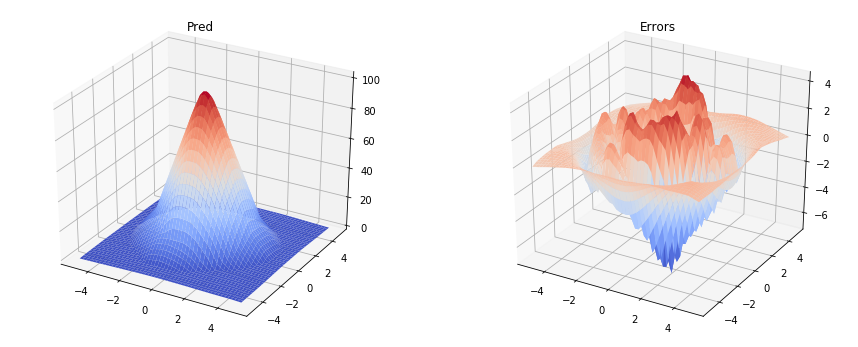

In [18]:
print(estimator.evaluate(input_fn=predict_input_fn))
plot3d(X,Y, Z, Zout)

In [19]:
def fitandplot(layers, bs, epoch, lr):
    estimator = tcb.learn.Estimator(model_fn=model_fn2, params={"learning_rate": lr, "p": layers},
                                    config=tcb.learn.RunConfig(log_device_placement=False,
                                                               gpu_memory_fraction=0.8,
                                                               save_summary_steps=1000))
    input_fn = numpy_input_fn(x= {"X": X, "Y": Y}, y = Z, batch_size=bs, num_epochs=epoch, shuffle=True)
    start = time.time()
    y = estimator.fit(input_fn=input_fn)
    print("Time to run", time.time() - start)
    predict_input_fn = numpy_input_fn(x= {"X": X, "Y": Y}, y = Z, batch_size=5, num_epochs=1, shuffle=False)
    Zgo = estimator.predict(input_fn=predict_input_fn)
    Zout = np.array([x[0] for x in Zgo]).reshape(-1,1)
    print(estimator.evaluate(input_fn=predict_input_fn))
    return Zout

In [20]:
ZZ = fitandplot([10,2], 100, 100, 1e-3)

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5dcc6c75c0>, '_master': '', '_num_ps_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 0.8
}
, '_tf_random_seed': None, '_save_summary_steps': 1000, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000}
(?, 1) (?, 1) (?, 1) (?, 2)
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpmi0jfprw/model.ckpt.
INFO:tensorflow:loss = 1873.95, step = 1
INFO:tensorflow:global_step/sec: 285.284
INFO:tensorflow:loss = 1138.6, step = 101
INFO:tensorflow:global_step/sec: 281.602
INFO:tensorflow:loss = 1315.6, step = 201
INFO:tensorflow:global_step/sec: 287.636
INFO:tensorflow:loss = 959.049, step = 301
INFO:tensorflow:global_step/sec: 270

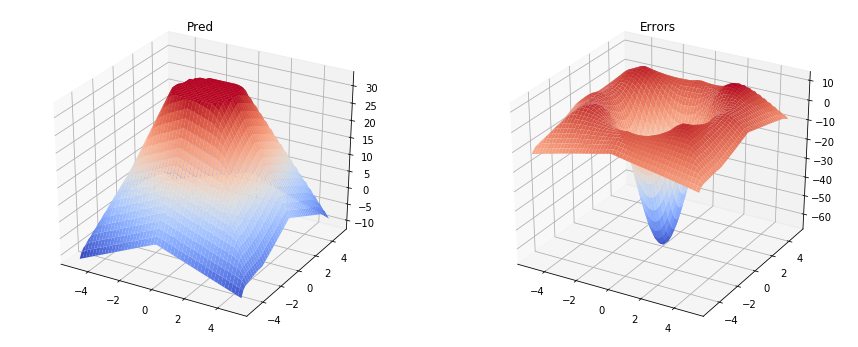

In [21]:
plot3d(X,Y,Z,ZZ)

In [22]:
#Trial 2 small rate
ZZ = fitandplot([10,2], 100, 100, 1e-5)

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5d6c85e278>, '_master': '', '_num_ps_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 0.8
}
, '_tf_random_seed': None, '_save_summary_steps': 1000, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000}
(?, 1) (?, 1) (?, 1) (?, 2)
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpcizo8nxe/model.ckpt.
INFO:tensorflow:loss = 180.995, step = 1
INFO:tensorflow:global_step/sec: 249.78
INFO:tensorflow:loss = 390.194, step = 101
INFO:tensorflow:global_step/sec: 246.237
INFO:tensorflow:loss = 306.413, step = 201
INFO:tensorflow:global_step/sec: 261.622
INFO:tensorflow:loss = 270.126, step = 301
INFO:tensorflow:global_step/sec: 26

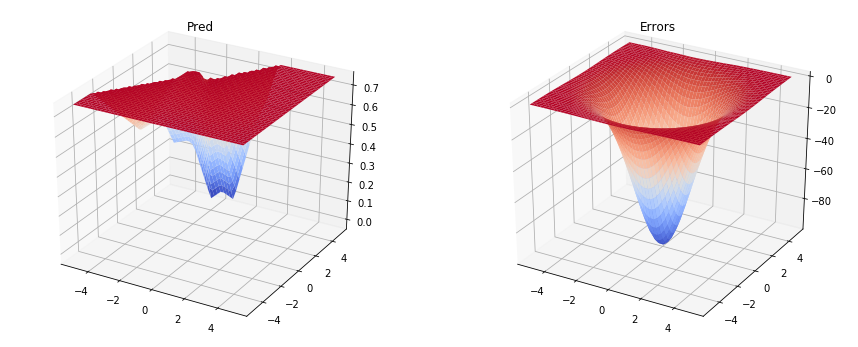

In [23]:
plot3d(X,Y,Z,ZZ)

In [24]:
# Trial 3
ZZ = fitandplot([10,2], 100, 100, 1e-5)

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5dcc890eb8>, '_master': '', '_num_ps_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 0.8
}
, '_tf_random_seed': None, '_save_summary_steps': 1000, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000}
(?, 1) (?, 1) (?, 1) (?, 2)
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpmv3crgft/model.ckpt.
INFO:tensorflow:loss = 1217.34, step = 1
INFO:tensorflow:global_step/sec: 262.706
INFO:tensorflow:loss = 691.443, step = 101
INFO:tensorflow:global_step/sec: 265.284
INFO:tensorflow:loss = 636.515, step = 201
INFO:tensorflow:global_step/sec: 266.597
INFO:tensorflow:loss = 570.462, step = 301
INFO:tensorflow:global_step/sec: 2

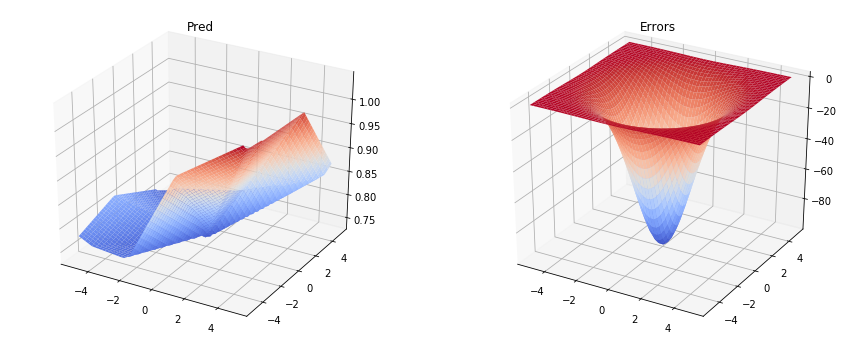

In [25]:
plot3d(X,Y,Z,ZZ)

In [26]:
# Trial 1 bigger rate
ZZ = fitandplot([10,2], 100, 100, 1e-3)

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5cfc0c3470>, '_master': '', '_num_ps_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 0.8
}
, '_tf_random_seed': None, '_save_summary_steps': 1000, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000}
(?, 1) (?, 1) (?, 1) (?, 2)
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpe1svj89p/model.ckpt.
INFO:tensorflow:loss = 233.034, step = 1
INFO:tensorflow:global_step/sec: 243.37
INFO:tensorflow:loss = 268.11, step = 101
INFO:tensorflow:global_step/sec: 249.4
INFO:tensorflow:loss = 7.6097, step = 201
INFO:tensorflow:global_step/sec: 273.802
INFO:tensorflow:loss = 7.03587, step = 301
INFO:tensorflow:global_step/sec: 275.76

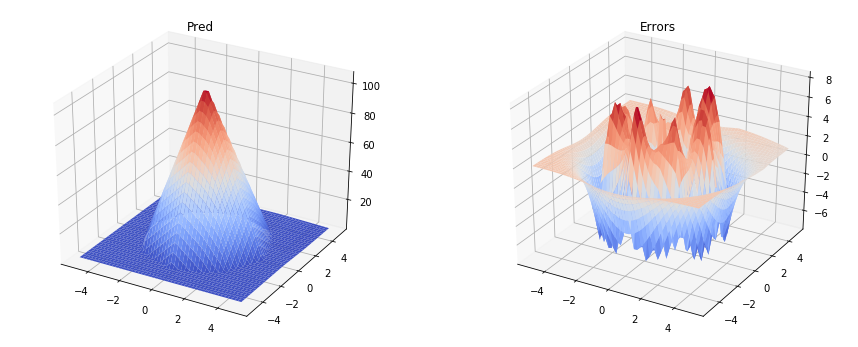

In [27]:
plot3d(X,Y,Z,ZZ)

In [28]:
# Trial 1 bigger rate
ZZ = fitandplot([10,2], 100, 100, 1e-3)

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5cffb04828>, '_master': '', '_num_ps_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 0.8
}
, '_tf_random_seed': None, '_save_summary_steps': 1000, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000}
(?, 1) (?, 1) (?, 1) (?, 2)
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpl5ke7o_w/model.ckpt.
INFO:tensorflow:loss = 1570.67, step = 1
INFO:tensorflow:global_step/sec: 245.108
INFO:tensorflow:loss = 424.703, step = 101
INFO:tensorflow:global_step/sec: 251.147
INFO:tensorflow:loss = 16.4564, step = 201
INFO:tensorflow:global_step/sec: 260.184
INFO:tensorflow:loss = 17.2412, step = 301
INFO:tensorflow:global_step/sec: 2

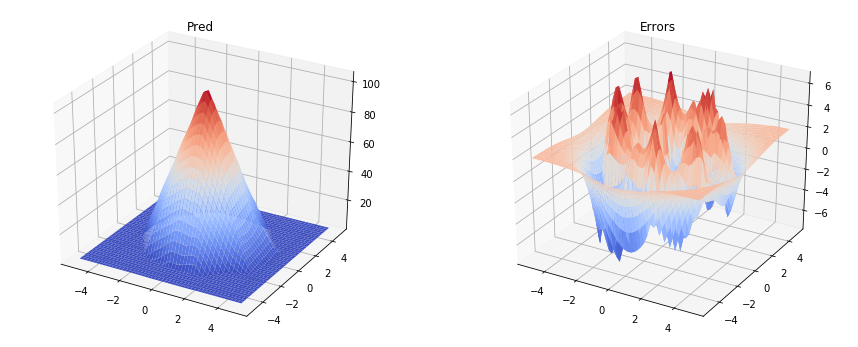

In [29]:
plot3d(X,Y,Z,ZZ)

In [30]:
# Trial 1 epoch + smaller rate
ZZ = fitandplot([10,2], 100, 1000, 1e-5)

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5ce4122ef0>, '_master': '', '_num_ps_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 0.8
}
, '_tf_random_seed': None, '_save_summary_steps': 1000, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000}
(?, 1) (?, 1) (?, 1) (?, 2)
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpqsfbujlp/model.ckpt.
INFO:tensorflow:loss = 691.935, step = 1
INFO:tensorflow:global_step/sec: 260.511
INFO:tensorflow:loss = 852.964, step = 101
INFO:tensorflow:global_step/sec: 245.504
INFO:tensorflow:loss = 457.334, step = 201
INFO:tensorflow:global_step/sec: 241.912
INFO:tensorflow:loss = 777.486, step = 301
INFO:tensorflow:global_step/sec: 2

INFO:tensorflow:loss = 363.489, step = 8801
INFO:tensorflow:global_step/sec: 229.602
INFO:tensorflow:loss = 362.946, step = 8901
INFO:tensorflow:global_step/sec: 232.688
INFO:tensorflow:loss = 263.362, step = 9001
INFO:tensorflow:global_step/sec: 234.575
INFO:tensorflow:loss = 289.889, step = 9101
INFO:tensorflow:global_step/sec: 238.969
INFO:tensorflow:loss = 247.044, step = 9201
INFO:tensorflow:global_step/sec: 238.741
INFO:tensorflow:loss = 274.744, step = 9301
INFO:tensorflow:global_step/sec: 237.042
INFO:tensorflow:loss = 359.22, step = 9401
INFO:tensorflow:global_step/sec: 234.814
INFO:tensorflow:loss = 212.365, step = 9501
INFO:tensorflow:global_step/sec: 238.216
INFO:tensorflow:loss = 261.294, step = 9601
INFO:tensorflow:global_step/sec: 233.665
INFO:tensorflow:loss = 250.783, step = 9701
INFO:tensorflow:global_step/sec: 235.121
INFO:tensorflow:loss = 297.486, step = 9801
INFO:tensorflow:global_step/sec: 240.457
INFO:tensorflow:loss = 138.663, step = 9901
INFO:tensorflow:global

INFO:tensorflow:loss = 10.6947, step = 18401
INFO:tensorflow:global_step/sec: 250.858
INFO:tensorflow:loss = 12.6818, step = 18501
INFO:tensorflow:global_step/sec: 248.651
INFO:tensorflow:loss = 13.1089, step = 18601
INFO:tensorflow:global_step/sec: 242.986
INFO:tensorflow:loss = 11.6524, step = 18701
INFO:tensorflow:global_step/sec: 247.782
INFO:tensorflow:loss = 9.99327, step = 18801
INFO:tensorflow:global_step/sec: 255.665
INFO:tensorflow:loss = 9.7094, step = 18901
INFO:tensorflow:global_step/sec: 257.723
INFO:tensorflow:loss = 13.0554, step = 19001
INFO:tensorflow:global_step/sec: 256.922
INFO:tensorflow:loss = 8.33162, step = 19101
INFO:tensorflow:global_step/sec: 270.777
INFO:tensorflow:loss = 10.5093, step = 19201
INFO:tensorflow:global_step/sec: 281.955
INFO:tensorflow:loss = 10.929, step = 19301
INFO:tensorflow:global_step/sec: 266.123
INFO:tensorflow:loss = 10.4946, step = 19401
INFO:tensorflow:global_step/sec: 272.35
INFO:tensorflow:loss = 8.51056, step = 19501
INFO:tensorf

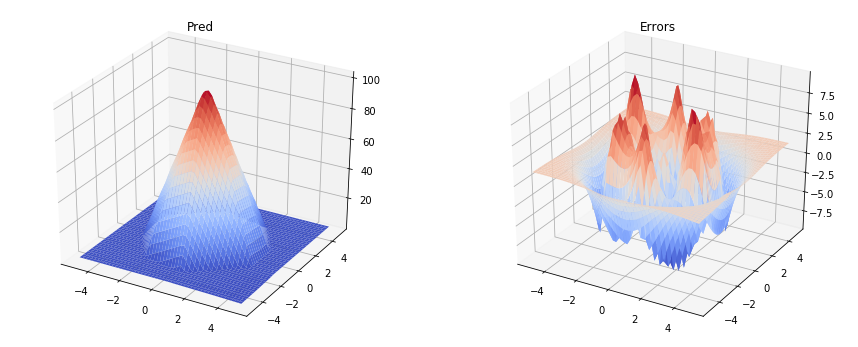

In [31]:
plot3d(X,Y,Z,ZZ)

In [32]:
# Trial 2 epoch + smaller rate
ZZ = fitandplot([10,2], 100, 1000, 1e-5)

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5ce42d5828>, '_master': '', '_num_ps_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 0.8
}
, '_tf_random_seed': None, '_save_summary_steps': 1000, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000}
(?, 1) (?, 1) (?, 1) (?, 2)
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpye5qutfw/model.ckpt.
INFO:tensorflow:loss = 1464.02, step = 1
INFO:tensorflow:global_step/sec: 257.423
INFO:tensorflow:loss = 1279.51, step = 101
INFO:tensorflow:global_step/sec: 254.47
INFO:tensorflow:loss = 1168.83, step = 201
INFO:tensorflow:global_step/sec: 269.494
INFO:tensorflow:loss = 1438.41, step = 301
INFO:tensorflow:global_step/sec: 26

INFO:tensorflow:loss = 615.708, step = 8801
INFO:tensorflow:global_step/sec: 229.734
INFO:tensorflow:loss = 374.988, step = 8901
INFO:tensorflow:global_step/sec: 235.6
INFO:tensorflow:loss = 302.55, step = 9001
INFO:tensorflow:global_step/sec: 239.293
INFO:tensorflow:loss = 285.959, step = 9101
INFO:tensorflow:global_step/sec: 238.235
INFO:tensorflow:loss = 389.866, step = 9201
INFO:tensorflow:global_step/sec: 233.942
INFO:tensorflow:loss = 408.236, step = 9301
INFO:tensorflow:global_step/sec: 239.935
INFO:tensorflow:loss = 227.485, step = 9401
INFO:tensorflow:global_step/sec: 241.588
INFO:tensorflow:loss = 358.839, step = 9501
INFO:tensorflow:global_step/sec: 239.438
INFO:tensorflow:loss = 268.009, step = 9601
INFO:tensorflow:global_step/sec: 232.696
INFO:tensorflow:loss = 413.877, step = 9701
INFO:tensorflow:global_step/sec: 232.349
INFO:tensorflow:loss = 225.237, step = 9801
INFO:tensorflow:global_step/sec: 231.894
INFO:tensorflow:loss = 338.667, step = 9901
INFO:tensorflow:global_s

INFO:tensorflow:loss = 17.8388, step = 18401
INFO:tensorflow:global_step/sec: 244.04
INFO:tensorflow:loss = 14.4758, step = 18501
INFO:tensorflow:global_step/sec: 243.302
INFO:tensorflow:loss = 13.826, step = 18601
INFO:tensorflow:global_step/sec: 238.719
INFO:tensorflow:loss = 12.6975, step = 18701
INFO:tensorflow:global_step/sec: 236.959
INFO:tensorflow:loss = 16.6378, step = 18801
INFO:tensorflow:global_step/sec: 249.569
INFO:tensorflow:loss = 15.1787, step = 18901
INFO:tensorflow:global_step/sec: 251.317
INFO:tensorflow:loss = 14.2435, step = 19001
INFO:tensorflow:global_step/sec: 260.159
INFO:tensorflow:loss = 15.3064, step = 19101
INFO:tensorflow:global_step/sec: 254.4
INFO:tensorflow:loss = 13.5025, step = 19201
INFO:tensorflow:global_step/sec: 266.311
INFO:tensorflow:loss = 17.0442, step = 19301
INFO:tensorflow:global_step/sec: 271.644
INFO:tensorflow:loss = 14.8035, step = 19401
INFO:tensorflow:global_step/sec: 274.817
INFO:tensorflow:loss = 15.5606, step = 19501
INFO:tensorfl

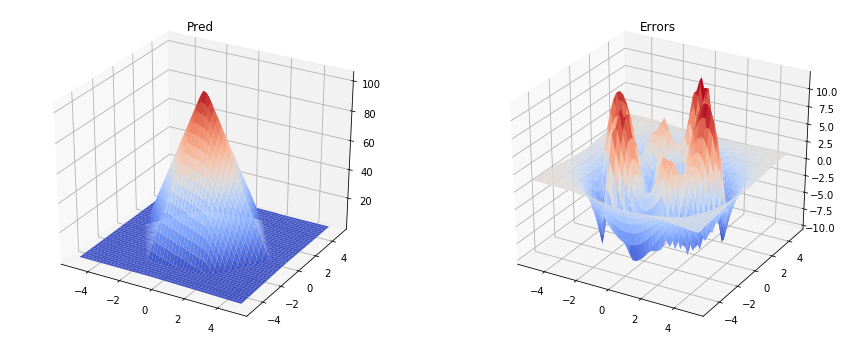

In [33]:
plot3d(X,Y,Z,ZZ)

In [34]:
# Trial 1 bigger layers + big rate + small epoch
ZZ = fitandplot([100,20], 100, 100, 1e-3)

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5d94047400>, '_master': '', '_num_ps_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 0.8
}
, '_tf_random_seed': None, '_save_summary_steps': 1000, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000}
(?, 1) (?, 1) (?, 1) (?, 2)
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpami4gnpf/model.ckpt.
INFO:tensorflow:loss = 1482.42, step = 1
INFO:tensorflow:global_step/sec: 276.526
INFO:tensorflow:loss = 211.59, step = 101
INFO:tensorflow:global_step/sec: 266.674
INFO:tensorflow:loss = 2.87055, step = 201
INFO:tensorflow:global_step/sec: 269.679
INFO:tensorflow:loss = 0.99944, step = 301
INFO:tensorflow:global_step/sec: 28

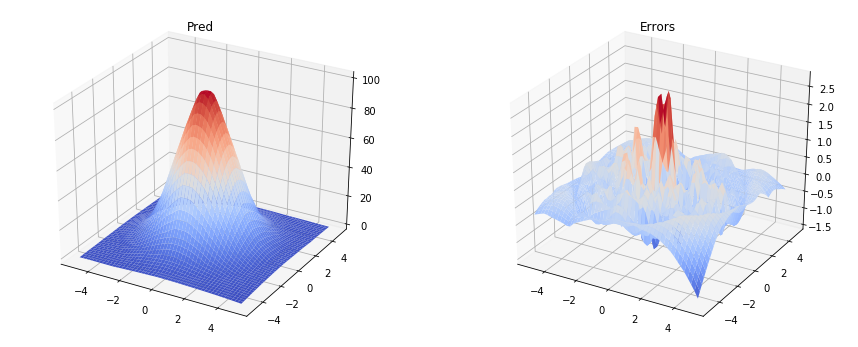

In [35]:
plot3d(X,Y,Z,ZZ)

In [36]:
# Trial 2 bigger layers + big rate + small epoch
ZZ = fitandplot([100,20], 100, 100, 1e-3)

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5d740447f0>, '_master': '', '_num_ps_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 0.8
}
, '_tf_random_seed': None, '_save_summary_steps': 1000, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000}
(?, 1) (?, 1) (?, 1) (?, 2)
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpm7d302x2/model.ckpt.
INFO:tensorflow:loss = 13.5157, step = 1
INFO:tensorflow:global_step/sec: 276.271
INFO:tensorflow:loss = 92.9383, step = 101
INFO:tensorflow:global_step/sec: 302.869
INFO:tensorflow:loss = 1.404, step = 201
INFO:tensorflow:global_step/sec: 285.715
INFO:tensorflow:loss = 0.403708, step = 301
INFO:tensorflow:global_step/sec: 29

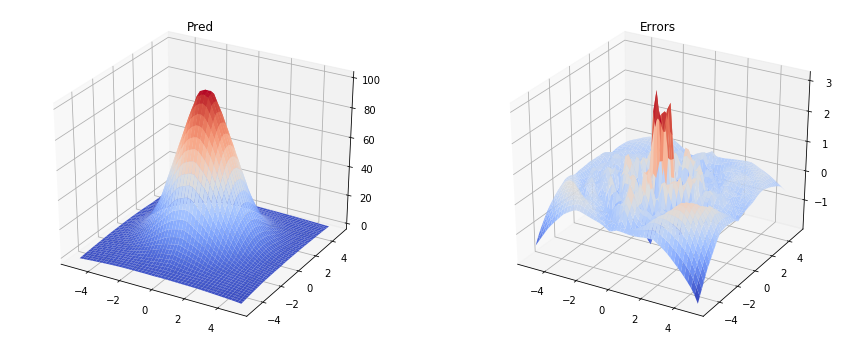

In [37]:
plot3d(X,Y,Z,ZZ)

In [38]:
# Trial 1 bigger layers + big rate + big epoch
ZZ = fitandplot([100,20], 100, 1000, 1e-3)

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5ce42225c0>, '_master': '', '_num_ps_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 0.8
}
, '_tf_random_seed': None, '_save_summary_steps': 1000, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000}
(?, 1) (?, 1) (?, 1) (?, 2)
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp_mxpcyj3/model.ckpt.
INFO:tensorflow:loss = 39.1142, step = 1
INFO:tensorflow:global_step/sec: 298.306
INFO:tensorflow:loss = 242.292, step = 101
INFO:tensorflow:global_step/sec: 288.569
INFO:tensorflow:loss = 1.71907, step = 201
INFO:tensorflow:global_step/sec: 280.761
INFO:tensorflow:loss = 0.643071, step = 301
INFO:tensorflow:global_step/sec: 

INFO:tensorflow:loss = 0.0831417, step = 8701
INFO:tensorflow:global_step/sec: 258.686
INFO:tensorflow:loss = 0.0946035, step = 8801
INFO:tensorflow:global_step/sec: 258.266
INFO:tensorflow:loss = 0.0903335, step = 8901
INFO:tensorflow:global_step/sec: 261.435
INFO:tensorflow:loss = 0.0734463, step = 9001
INFO:tensorflow:global_step/sec: 259.916
INFO:tensorflow:loss = 0.0917543, step = 9101
INFO:tensorflow:global_step/sec: 259.254
INFO:tensorflow:loss = 0.0745975, step = 9201
INFO:tensorflow:global_step/sec: 265.938
INFO:tensorflow:loss = 0.0650373, step = 9301
INFO:tensorflow:global_step/sec: 264.213
INFO:tensorflow:loss = 0.067534, step = 9401
INFO:tensorflow:global_step/sec: 261.12
INFO:tensorflow:loss = 0.0726457, step = 9501
INFO:tensorflow:global_step/sec: 264.359
INFO:tensorflow:loss = 0.0922667, step = 9601
INFO:tensorflow:global_step/sec: 261.475
INFO:tensorflow:loss = 0.106261, step = 9701
INFO:tensorflow:global_step/sec: 255.968
INFO:tensorflow:loss = 0.0852547, step = 9801


INFO:tensorflow:loss = 0.0996278, step = 18101
INFO:tensorflow:global_step/sec: 259.114
INFO:tensorflow:loss = 0.0494563, step = 18201
INFO:tensorflow:global_step/sec: 258.785
INFO:tensorflow:loss = 0.0660344, step = 18301
INFO:tensorflow:global_step/sec: 261.154
INFO:tensorflow:loss = 0.058261, step = 18401
INFO:tensorflow:global_step/sec: 270.902
INFO:tensorflow:loss = 0.0718585, step = 18501
INFO:tensorflow:global_step/sec: 266.356
INFO:tensorflow:loss = 0.0737916, step = 18601
INFO:tensorflow:global_step/sec: 263.118
INFO:tensorflow:loss = 0.0948015, step = 18701
INFO:tensorflow:global_step/sec: 258.5
INFO:tensorflow:loss = 0.0618977, step = 18801
INFO:tensorflow:global_step/sec: 259.438
INFO:tensorflow:loss = 0.0620844, step = 18901
INFO:tensorflow:global_step/sec: 255.508
INFO:tensorflow:loss = 0.0496707, step = 19001
INFO:tensorflow:global_step/sec: 258.414
INFO:tensorflow:loss = 0.0815778, step = 19101
INFO:tensorflow:global_step/sec: 258.965
INFO:tensorflow:loss = 0.0563111, s

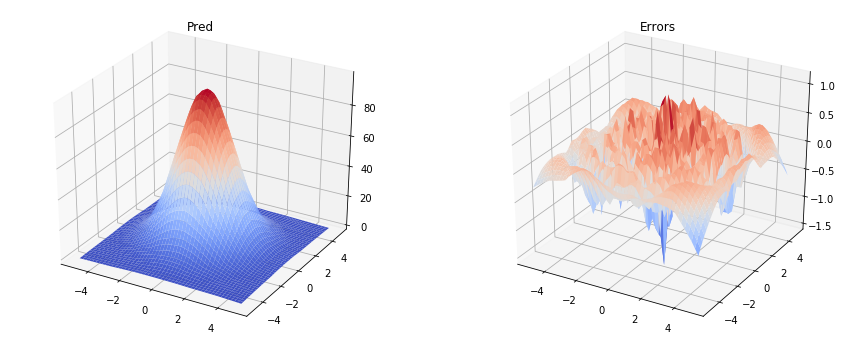

In [39]:
plot3d(X,Y,Z,ZZ)

In [40]:
# Trial 2 bigger layers + big rate + big epoch
ZZ = fitandplot([100,20], 100, 1000, 1e-3)

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5d74093da0>, '_master': '', '_num_ps_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 0.8
}
, '_tf_random_seed': None, '_save_summary_steps': 1000, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000}
(?, 1) (?, 1) (?, 1) (?, 2)
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmplxcrur5n/model.ckpt.
INFO:tensorflow:loss = 2004.49, step = 1
INFO:tensorflow:global_step/sec: 279.014
INFO:tensorflow:loss = 336.682, step = 101
INFO:tensorflow:global_step/sec: 273.355
INFO:tensorflow:loss = 2.58756, step = 201
INFO:tensorflow:global_step/sec: 279.208
INFO:tensorflow:loss = 1.28855, step = 301
INFO:tensorflow:global_step/sec: 2

INFO:tensorflow:loss = 0.349446, step = 8701
INFO:tensorflow:global_step/sec: 270.893
INFO:tensorflow:loss = 0.290604, step = 8801
INFO:tensorflow:global_step/sec: 279.424
INFO:tensorflow:loss = 0.400321, step = 8901
INFO:tensorflow:global_step/sec: 281.05
INFO:tensorflow:loss = 0.473427, step = 9001
INFO:tensorflow:global_step/sec: 273.548
INFO:tensorflow:loss = 0.458872, step = 9101
INFO:tensorflow:global_step/sec: 276.028
INFO:tensorflow:loss = 0.369081, step = 9201
INFO:tensorflow:global_step/sec: 277.811
INFO:tensorflow:loss = 0.367058, step = 9301
INFO:tensorflow:global_step/sec: 268.977
INFO:tensorflow:loss = 0.356577, step = 9401
INFO:tensorflow:global_step/sec: 277.677
INFO:tensorflow:loss = 0.456757, step = 9501
INFO:tensorflow:global_step/sec: 277.517
INFO:tensorflow:loss = 0.454883, step = 9601
INFO:tensorflow:global_step/sec: 268.886
INFO:tensorflow:loss = 0.383259, step = 9701
INFO:tensorflow:global_step/sec: 282.988
INFO:tensorflow:loss = 0.33926, step = 9801
INFO:tensor

INFO:tensorflow:global_step/sec: 258.565
INFO:tensorflow:loss = 0.320415, step = 18201
INFO:tensorflow:global_step/sec: 263.544
INFO:tensorflow:loss = 0.284677, step = 18301
INFO:tensorflow:global_step/sec: 263.301
INFO:tensorflow:loss = 0.408245, step = 18401
INFO:tensorflow:global_step/sec: 261.201
INFO:tensorflow:loss = 0.503692, step = 18501
INFO:tensorflow:global_step/sec: 265.113
INFO:tensorflow:loss = 0.292054, step = 18601
INFO:tensorflow:global_step/sec: 260.672
INFO:tensorflow:loss = 0.34636, step = 18701
INFO:tensorflow:global_step/sec: 264.518
INFO:tensorflow:loss = 0.330422, step = 18801
INFO:tensorflow:global_step/sec: 260.143
INFO:tensorflow:loss = 0.409541, step = 18901
INFO:tensorflow:global_step/sec: 269.882
INFO:tensorflow:loss = 0.399575, step = 19001
INFO:tensorflow:global_step/sec: 255.776
INFO:tensorflow:loss = 0.287043, step = 19101
INFO:tensorflow:global_step/sec: 262.774
INFO:tensorflow:loss = 0.333867, step = 19201
INFO:tensorflow:global_step/sec: 264.681
INF

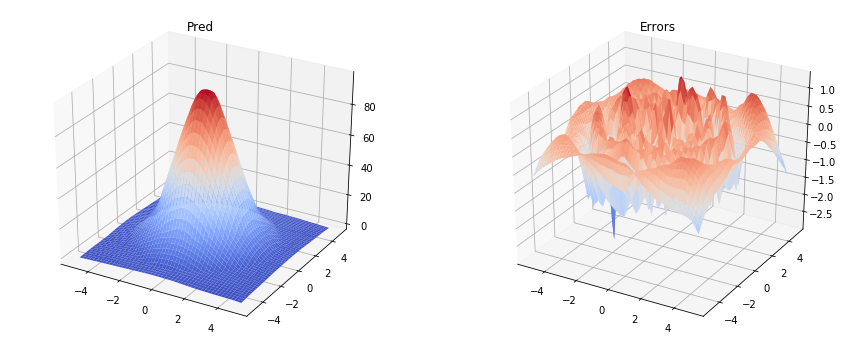

In [41]:
plot3d(X,Y,Z,ZZ)

In [42]:
# Trial 1 jumbo layers + big rate + small epoch
ZZ = fitandplot([1000,100], 100, 100, 1e-3)

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5dcc717320>, '_master': '', '_num_ps_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 0.8
}
, '_tf_random_seed': None, '_save_summary_steps': 1000, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000}
(?, 1) (?, 1) (?, 1) (?, 2)
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpkeo3wcwc/model.ckpt.
INFO:tensorflow:loss = 163.163, step = 1
INFO:tensorflow:global_step/sec: 252.198
INFO:tensorflow:loss = 121.212, step = 101
INFO:tensorflow:global_step/sec: 239.877
INFO:tensorflow:loss = 1.66052, step = 201
INFO:tensorflow:global_step/sec: 239.765
INFO:tensorflow:loss = 0.449306, step = 301
INFO:tensorflow:global_step/sec: 

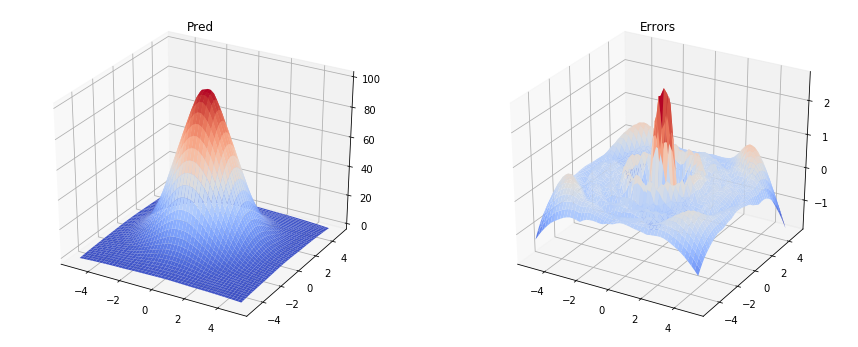

In [43]:
plot3d(X,Y,Z,ZZ)

In [44]:
# Trial 1 jumbo layers + big rate + big epoch
ZZ = fitandplot([1000,100], 100, 1000, 1e-3)

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5dcba4aac8>, '_master': '', '_num_ps_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 0.8
}
, '_tf_random_seed': None, '_save_summary_steps': 1000, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000}
(?, 1) (?, 1) (?, 1) (?, 2)
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpwrmwdrnh/model.ckpt.
INFO:tensorflow:loss = 20.4942, step = 1
INFO:tensorflow:global_step/sec: 254.291
INFO:tensorflow:loss = 64.6487, step = 101
INFO:tensorflow:global_step/sec: 259.88
INFO:tensorflow:loss = 0.65886, step = 201
INFO:tensorflow:global_step/sec: 255.617
INFO:tensorflow:loss = 0.298148, step = 301
INFO:tensorflow:global_step/sec: 2

INFO:tensorflow:global_step/sec: 247.236
INFO:tensorflow:loss = 0.0248839, step = 8701
INFO:tensorflow:global_step/sec: 244.669
INFO:tensorflow:loss = 0.0223059, step = 8801
INFO:tensorflow:global_step/sec: 245.153
INFO:tensorflow:loss = 0.0190373, step = 8901
INFO:tensorflow:global_step/sec: 243.165
INFO:tensorflow:loss = 0.0227301, step = 9001
INFO:tensorflow:global_step/sec: 246.27
INFO:tensorflow:loss = 0.0177056, step = 9101
INFO:tensorflow:global_step/sec: 246.099
INFO:tensorflow:loss = 0.0366885, step = 9201
INFO:tensorflow:global_step/sec: 246.559
INFO:tensorflow:loss = 0.0304633, step = 9301
INFO:tensorflow:global_step/sec: 240.783
INFO:tensorflow:loss = 0.0194457, step = 9401
INFO:tensorflow:global_step/sec: 245.235
INFO:tensorflow:loss = 0.0393763, step = 9501
INFO:tensorflow:global_step/sec: 244.749
INFO:tensorflow:loss = 0.023152, step = 9601
INFO:tensorflow:global_step/sec: 242.568
INFO:tensorflow:loss = 0.033126, step = 9701
INFO:tensorflow:global_step/sec: 241.539
INFO:

INFO:tensorflow:loss = 0.00977414, step = 18001
INFO:tensorflow:global_step/sec: 258.943
INFO:tensorflow:loss = 0.0170162, step = 18101
INFO:tensorflow:global_step/sec: 261.64
INFO:tensorflow:loss = 0.0100155, step = 18201
INFO:tensorflow:global_step/sec: 251.439
INFO:tensorflow:loss = 0.0112554, step = 18301
INFO:tensorflow:global_step/sec: 244.152
INFO:tensorflow:loss = 0.017716, step = 18401
INFO:tensorflow:global_step/sec: 246.909
INFO:tensorflow:loss = 0.0117405, step = 18501
INFO:tensorflow:global_step/sec: 261.641
INFO:tensorflow:loss = 0.0129503, step = 18601
INFO:tensorflow:global_step/sec: 266.539
INFO:tensorflow:loss = 0.0129887, step = 18701
INFO:tensorflow:global_step/sec: 264.229
INFO:tensorflow:loss = 0.00958029, step = 18801
INFO:tensorflow:global_step/sec: 245.573
INFO:tensorflow:loss = 0.00967072, step = 18901
INFO:tensorflow:global_step/sec: 244.162
INFO:tensorflow:loss = 0.0111501, step = 19001
INFO:tensorflow:global_step/sec: 239.673
INFO:tensorflow:loss = 0.014401

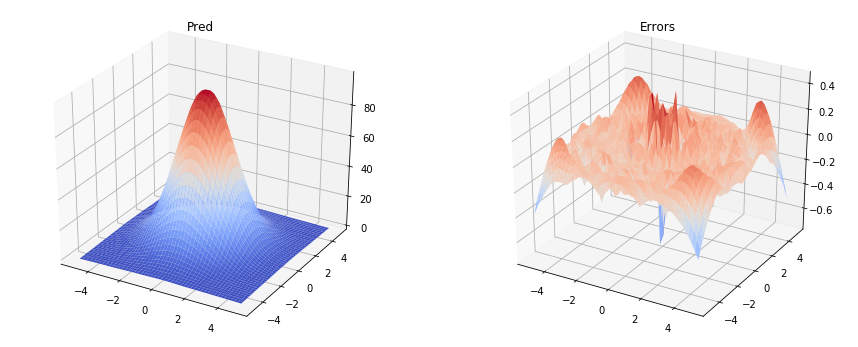

In [45]:
plot3d(X,Y,Z,ZZ)

In [46]:
# Trial 1 3 layer
ZZ = fitandplot([1000,100, 10], 100, 1000, 1e-3)

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5cfc1d0828>, '_master': '', '_num_ps_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 0.8
}
, '_tf_random_seed': None, '_save_summary_steps': 1000, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000}
(?, 1) (?, 1) (?, 1) (?, 2)
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmps77wcmfl/model.ckpt.
INFO:tensorflow:loss = 1049.42, step = 1
INFO:tensorflow:global_step/sec: 222.963
INFO:tensorflow:loss = 215.565, step = 101
INFO:tensorflow:global_step/sec: 221.518
INFO:tensorflow:loss = 67.8858, step = 201
INFO:tensorflow:global_step/sec: 218.799
INFO:tensorflow:loss = 2.89632, step = 301
INFO:tensorflow:global_step/sec: 2

INFO:tensorflow:loss = 0.263199, step = 8701
INFO:tensorflow:global_step/sec: 231.63
INFO:tensorflow:loss = 0.233329, step = 8801
INFO:tensorflow:global_step/sec: 224.424
INFO:tensorflow:loss = 0.2271, step = 8901
INFO:tensorflow:global_step/sec: 224.082
INFO:tensorflow:loss = 0.658867, step = 9001
INFO:tensorflow:global_step/sec: 217.925
INFO:tensorflow:loss = 0.0446806, step = 9101
INFO:tensorflow:global_step/sec: 216.26
INFO:tensorflow:loss = 0.0298156, step = 9201
INFO:tensorflow:global_step/sec: 220.824
INFO:tensorflow:loss = 0.0802729, step = 9301
INFO:tensorflow:global_step/sec: 221.408
INFO:tensorflow:loss = 0.0062347, step = 9401
INFO:tensorflow:global_step/sec: 219.53
INFO:tensorflow:loss = 0.0429022, step = 9501
INFO:tensorflow:global_step/sec: 223.406
INFO:tensorflow:loss = 0.0428172, step = 9601
INFO:tensorflow:global_step/sec: 229.614
INFO:tensorflow:loss = 0.0142434, step = 9701
INFO:tensorflow:global_step/sec: 220.602
INFO:tensorflow:loss = 0.217772, step = 9801
INFO:te

INFO:tensorflow:loss = 0.00576793, step = 18101
INFO:tensorflow:global_step/sec: 243.072
INFO:tensorflow:loss = 0.00665239, step = 18201
INFO:tensorflow:global_step/sec: 231.346
INFO:tensorflow:loss = 0.011835, step = 18301
INFO:tensorflow:global_step/sec: 229.807
INFO:tensorflow:loss = 0.0271762, step = 18401
INFO:tensorflow:global_step/sec: 231.832
INFO:tensorflow:loss = 0.0438758, step = 18501
INFO:tensorflow:global_step/sec: 229.133
INFO:tensorflow:loss = 0.00522497, step = 18601
INFO:tensorflow:global_step/sec: 229.192
INFO:tensorflow:loss = 0.00804606, step = 18701
INFO:tensorflow:global_step/sec: 235.122
INFO:tensorflow:loss = 0.0284121, step = 18801
INFO:tensorflow:global_step/sec: 247.72
INFO:tensorflow:loss = 0.0180707, step = 18901
INFO:tensorflow:global_step/sec: 237.38
INFO:tensorflow:loss = 0.099683, step = 19001
INFO:tensorflow:global_step/sec: 242.573
INFO:tensorflow:loss = 0.00835096, step = 19101
INFO:tensorflow:global_step/sec: 224.803
INFO:tensorflow:loss = 0.011444

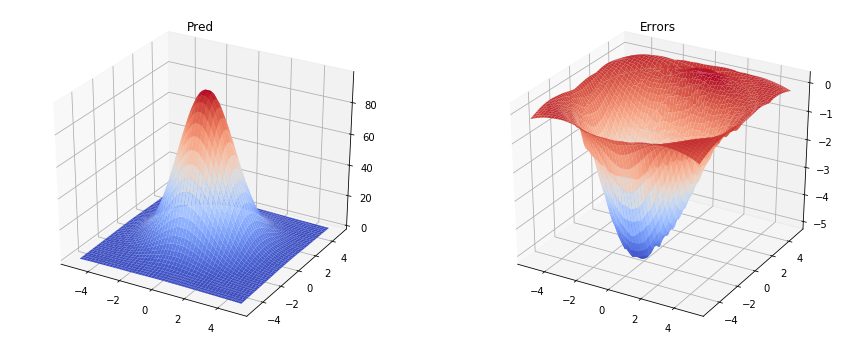

In [47]:
plot3d(X,Y,Z,ZZ)

In [48]:
# Trial 2 5 layers
ZZ = fitandplot([1000,100, 10, 10, 10], 100, 1000, 1e-3)

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5d6c56ffd0>, '_master': '', '_num_ps_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 0.8
}
, '_tf_random_seed': None, '_save_summary_steps': 1000, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000}
(?, 1) (?, 1) (?, 1) (?, 2)
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp03lrmjyi/model.ckpt.
INFO:tensorflow:loss = 919.181, step = 1
INFO:tensorflow:global_step/sec: 186.57
INFO:tensorflow:loss = 427.033, step = 101
INFO:tensorflow:global_step/sec: 210.366
INFO:tensorflow:loss = 0.367429, step = 201
INFO:tensorflow:global_step/sec: 225.153
INFO:tensorflow:loss = 0.947568, step = 301
INFO:tensorflow:global_step/sec: 

INFO:tensorflow:global_step/sec: 220.117
INFO:tensorflow:loss = 0.0394377, step = 8701
INFO:tensorflow:global_step/sec: 228.156
INFO:tensorflow:loss = 0.0321234, step = 8801
INFO:tensorflow:global_step/sec: 228.038
INFO:tensorflow:loss = 0.0385564, step = 8901
INFO:tensorflow:global_step/sec: 229.963
INFO:tensorflow:loss = 0.0366212, step = 9001
INFO:tensorflow:global_step/sec: 235.989
INFO:tensorflow:loss = 0.0553646, step = 9101
INFO:tensorflow:global_step/sec: 229.877
INFO:tensorflow:loss = 0.0244251, step = 9201
INFO:tensorflow:global_step/sec: 223.844
INFO:tensorflow:loss = 0.0742204, step = 9301
INFO:tensorflow:global_step/sec: 226.874
INFO:tensorflow:loss = 0.0325614, step = 9401
INFO:tensorflow:global_step/sec: 223.531
INFO:tensorflow:loss = 0.0640829, step = 9501
INFO:tensorflow:global_step/sec: 223.384
INFO:tensorflow:loss = 0.0367045, step = 9601
INFO:tensorflow:global_step/sec: 214.068
INFO:tensorflow:loss = 0.066643, step = 9701
INFO:tensorflow:global_step/sec: 223.646
INF

INFO:tensorflow:loss = 0.0714529, step = 18001
INFO:tensorflow:global_step/sec: 231.803
INFO:tensorflow:loss = 0.0302958, step = 18101
INFO:tensorflow:global_step/sec: 227.216
INFO:tensorflow:loss = 0.0585459, step = 18201
INFO:tensorflow:global_step/sec: 228.643
INFO:tensorflow:loss = 0.0414489, step = 18301
INFO:tensorflow:global_step/sec: 229.029
INFO:tensorflow:loss = 0.0194246, step = 18401
INFO:tensorflow:global_step/sec: 229.326
INFO:tensorflow:loss = 0.0588144, step = 18501
INFO:tensorflow:global_step/sec: 226.711
INFO:tensorflow:loss = 0.0234787, step = 18601
INFO:tensorflow:global_step/sec: 228.884
INFO:tensorflow:loss = 0.034488, step = 18701
INFO:tensorflow:global_step/sec: 225.744
INFO:tensorflow:loss = 0.0446214, step = 18801
INFO:tensorflow:global_step/sec: 230.61
INFO:tensorflow:loss = 0.0273612, step = 18901
INFO:tensorflow:global_step/sec: 231.667
INFO:tensorflow:loss = 0.0297943, step = 19001
INFO:tensorflow:global_step/sec: 230.391
INFO:tensorflow:loss = 0.0286597, 

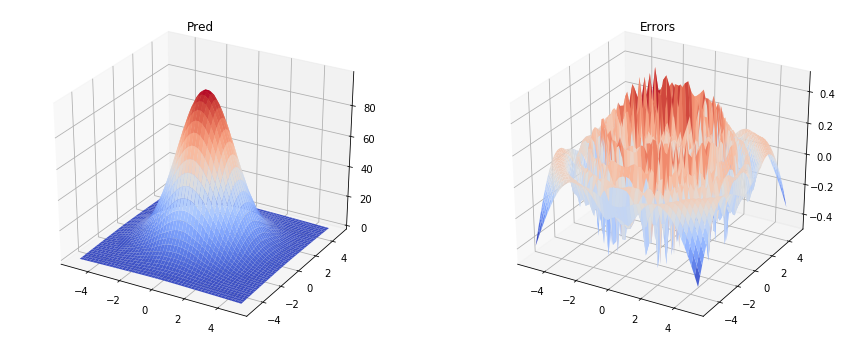

In [ ]:
plot3d(X,Y,Z,ZZ)

# Train with noisy data

Guassian noise of scale 5

**Will we get back the smooth curve?**

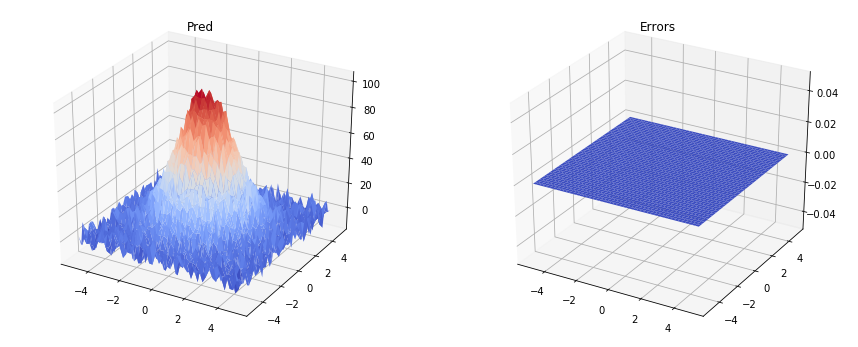

In [13]:
# Trial Noisy
Xn = np.linspace(-5,5, num = 50)
Yn = np.linspace(-5,5, num = 50)
Xn, Yn = np.meshgrid(Xn, Yn)

Zn = 100*np.exp(-1*(Xn**2 + Yn**2)/5)

Xn = Xn.reshape(-1,1)
Yn = Yn.reshape(-1,1)
Zn = Zn.reshape(-1,1) + np.random.normal(scale=5, size=Xn.shape[0]).reshape(-1,1)
plot3d(Xn,Yn,Zn,Zn)

In [14]:
def fitandplotnoisy(layers, bs, epoch, lr):
    estimator = tcb.learn.Estimator(model_fn=model_fn2, params={"learning_rate": lr, "p": layers},
                                    config=tcb.learn.RunConfig(log_device_placement=False,
                                                               gpu_memory_fraction=0.8,
                                                               save_summary_steps=1000))
    input_fn = numpy_input_fn(x= {"X": Xn, "Y": Yn}, y = Z, batch_size=bs, num_epochs=epoch, shuffle=True)
    start = time.time()
    y = estimator.fit(input_fn=input_fn)
    print("Time to run", time.time() - start)
    predict_input_fn = numpy_input_fn(x= {"X": Xn, "Y": Yn}, y = Zn, batch_size=5, num_epochs=1, shuffle=False)
    Zgo = estimator.predict(input_fn=predict_input_fn)
    Zout = np.array([x[0] for x in Zgo]).reshape(-1,1)
    print(estimator.evaluate(input_fn=predict_input_fn))
    return Zout

In [15]:
ZZ = fitandplotnoisy([100, 20], 100, 1000, 1e-3)

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7bcd2fe9e8>, '_master': '', '_num_ps_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 0.8
}
, '_tf_random_seed': None, '_save_summary_steps': 1000, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000}
(?, 1) (?, 1) (?, 1) (?, 2)
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpowfa7s4k/model.ckpt.
INFO:tensorflow:loss = 1879.55, step = 1
INFO:tensorflow:global_step/sec: 253.03
INFO:tensorflow:loss = 399.732, step = 101
INFO:tensorflow:global_step/sec: 256.807
INFO:tensorflow:loss = 4.69796, step = 201
INFO:tensorflow:global_step/sec: 259.661
INFO:tensorflow:loss = 1.25876, step = 301
INFO:tensorflow:global_step/sec: 27

INFO:tensorflow:loss = 0.204179, step = 8701
INFO:tensorflow:global_step/sec: 260.344
INFO:tensorflow:loss = 0.156549, step = 8801
INFO:tensorflow:global_step/sec: 255.152
INFO:tensorflow:loss = 0.225114, step = 8901
INFO:tensorflow:global_step/sec: 257.965
INFO:tensorflow:loss = 0.197348, step = 9001
INFO:tensorflow:global_step/sec: 267.616
INFO:tensorflow:loss = 0.223946, step = 9101
INFO:tensorflow:global_step/sec: 265.245
INFO:tensorflow:loss = 0.206073, step = 9201
INFO:tensorflow:global_step/sec: 264.787
INFO:tensorflow:loss = 0.215422, step = 9301
INFO:tensorflow:global_step/sec: 261.852
INFO:tensorflow:loss = 0.168321, step = 9401
INFO:tensorflow:global_step/sec: 259.272
INFO:tensorflow:loss = 0.206067, step = 9501
INFO:tensorflow:global_step/sec: 261.373
INFO:tensorflow:loss = 0.11186, step = 9601
INFO:tensorflow:global_step/sec: 260.963
INFO:tensorflow:loss = 0.151633, step = 9701
INFO:tensorflow:global_step/sec: 256.5
INFO:tensorflow:loss = 0.175108, step = 9801
INFO:tensorf

INFO:tensorflow:loss = 0.100124, step = 18201
INFO:tensorflow:global_step/sec: 261.078
INFO:tensorflow:loss = 0.146934, step = 18301
INFO:tensorflow:global_step/sec: 255.593
INFO:tensorflow:loss = 0.133653, step = 18401
INFO:tensorflow:global_step/sec: 261.202
INFO:tensorflow:loss = 0.134527, step = 18501
INFO:tensorflow:global_step/sec: 275.437
INFO:tensorflow:loss = 0.138859, step = 18601
INFO:tensorflow:global_step/sec: 269.476
INFO:tensorflow:loss = 0.148415, step = 18701
INFO:tensorflow:global_step/sec: 256.298
INFO:tensorflow:loss = 0.147627, step = 18801
INFO:tensorflow:global_step/sec: 256.562
INFO:tensorflow:loss = 0.161765, step = 18901
INFO:tensorflow:global_step/sec: 265.803
INFO:tensorflow:loss = 0.111782, step = 19001
INFO:tensorflow:global_step/sec: 274.332
INFO:tensorflow:loss = 0.113457, step = 19101
INFO:tensorflow:global_step/sec: 263.014
INFO:tensorflow:loss = 0.103179, step = 19201
INFO:tensorflow:global_step/sec: 262.933
INFO:tensorflow:loss = 0.170963, step = 193

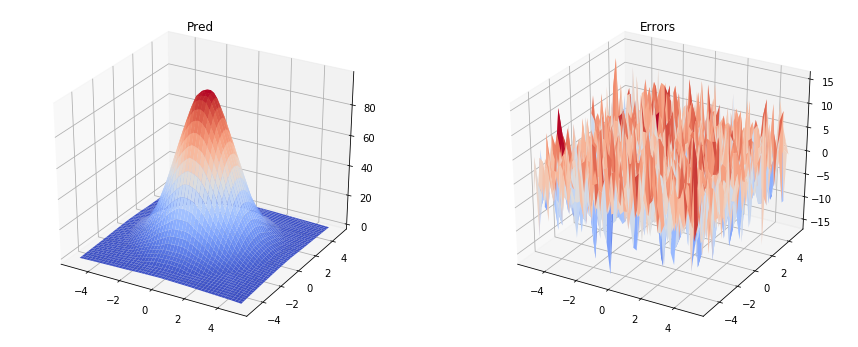

In [16]:
plot3d(Xn,Yn,Zn,ZZ)

**Yes we did!**